In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

#import custom modules
import sys
sys.path.insert(0,'/Users/frederickkorbel/Documents/projects/paper/mlcis/utils')

import integrated_gradients as ig
import my_utils
from metaplot import Metaplot,one_hot_encode
import plotseqlogo as sql

/Users/frederickkorbel/Documents/projects/paper/mlcis/utils/plotseqlogo.py:53: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/Users/frederickkorbel/Documents/projects/paper/mlcis/utils/plotseqlogo.py:54: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


In [3]:
from matplotlib.cbook import safe_masked_invalid


def plot_meta(data, model, subset=None):

    if subset is None:
        print(len(data))
        data_seq = one_hot_encode(data, seq_len=50)
        data_ig = ig.integrated_gradients(model, data_seq)
        Metaplot(data_ig, colorbar = True)
    
    elif subset == 'lowest_ten':
        data_lowest_ten = data[data['pred'] <= data['pred'].quantile(0.1)]
        print(len(data_lowest_ten))
        lowest_ten_seq = one_hot_encode(data_lowest_ten, seq_len=50)
        lowest_ten_ig = ig.integrated_gradients(model, lowest_ten_seq)
        Metaplot(lowest_ten_ig, colorbar = True)

    elif subset == 'highest_ten':
        data_highest_ten = data[data['pred'] >= data['pred'].quantile(0.9)]
        print(len(data_highest_ten))
        highest_ten_seq = one_hot_encode(data_highest_ten, seq_len=50)
        highest_ten_ig = ig.integrated_gradients(model, highest_ten_seq)
        Metaplot(highest_ten_ig, colorbar = True)
        
    else:
        raise ValueError()

def plot_attribution(data, model, subset=None, samples=10):
    if subset is None:
        print(len(data))
        data = data.sample(n=samples)
        data_seq = one_hot_encode(data, seq_len=50)
        data_ig = ig.integrated_gradients(model, data_seq)
        sql.seqlogo_fig(np.transpose(data_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)
    
    elif subset == 'lowest_ten':
        data_lowest_ten = data[data['pred'] <= data['pred'].quantile(0.1)].sample(n=samples)
        print(len(data_lowest_ten))
        lowest_ten_seq = one_hot_encode(data_lowest_ten, seq_len=50)
        lowest_ten_ig = ig.integrated_gradients(model, lowest_ten_seq)
        sql.seqlogo_fig(np.transpose(lowest_ten_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)

    elif subset == 'highest_ten':
        data_highest_ten = data[data['pred'] >= data['pred'].quantile(0.9)].sample(n=samples)
        print(len(data_highest_ten))
        highest_ten_seq = one_hot_encode(data_highest_ten, seq_len=50)
        highest_ten_ig = ig.integrated_gradients(model, highest_ten_seq)
        sql.seqlogo_fig(np.transpose(highest_ten_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,samples), ncol=1)
        
    else:
        raise ValueError()

We import datasets for which AUG-bearing reporters were removed and the respective models trained exclusively with nonAUG UTRs to perform attribution on both. 

In [7]:
#import utrs with measured and predicted mean ribosome load

#synthetic utrs with mean ribosome load predicted by MRL model (trained on synthetic utrs without AUG)
no_aug_pred_random=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/MRL_no_aug_random_test_pred.csv', index_col=[0])

#human utrs with mean ribosome load predicted by hMRL model (trained on human utrs without AUG)
no_aug_pred_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/hMRL_no_aug_human_test_pred.csv', index_col=[0])

#import the two models trained on human/synthetic utrs without AUG respectively
mrl_model_no_aug=tf.keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/MRL_model_no_aug.hdf5')
hmrl_model_no_aug=tf.keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/hMRL_model_no_aug.hdf5')

First, we attribute the MRL model trained on nonAUG synthetic UTRs.

5
5


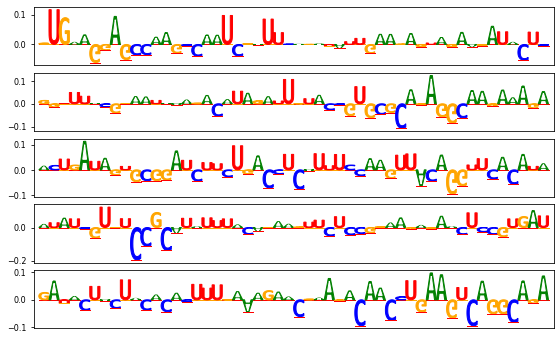

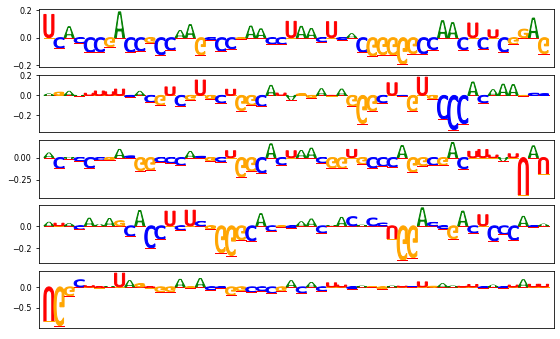

In [16]:
plot_attribution(no_aug_pred_random, mrl_model_no_aug, subset='highest_ten',samples=5)
plot_attribution(no_aug_pred_random, mrl_model_no_aug, subset='lowest_ten',samples=5)

602


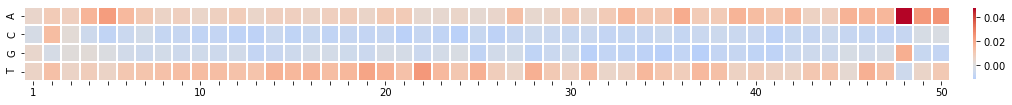

602


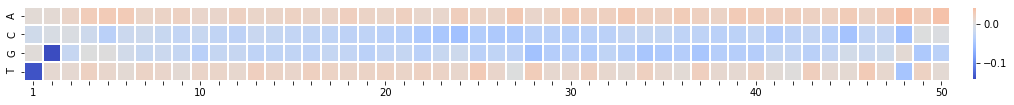

6014


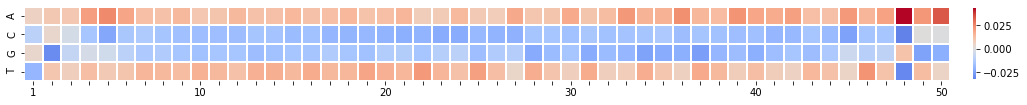

In [19]:
plot_meta(no_aug_pred_random, mrl_model_no_aug, subset = 'highest_ten')
plot_meta(no_aug_pred_random, mrl_model_no_aug, subset = 'lowest_ten')
plot_meta(no_aug_pred_random, mrl_model_no_aug)

5
5


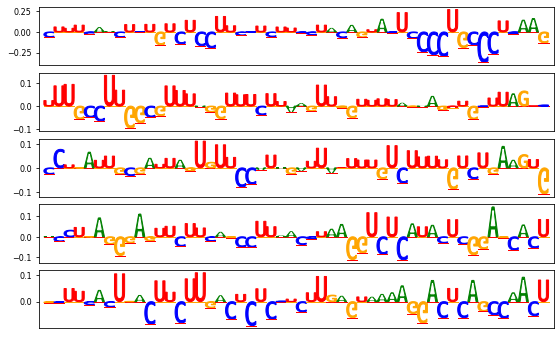

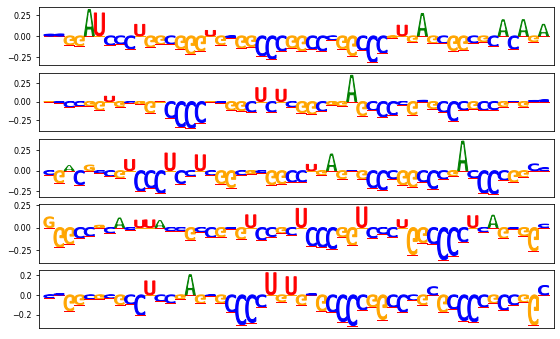

In [15]:
plot_attribution(no_aug_pred_human, hmrl_model_no_aug, subset='highest_ten',samples=5)
plot_attribution(no_aug_pred_human, hmrl_model_no_aug, subset='lowest_ten',samples=5)

395


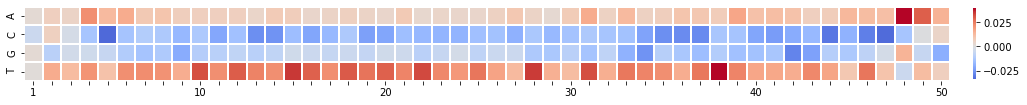

395


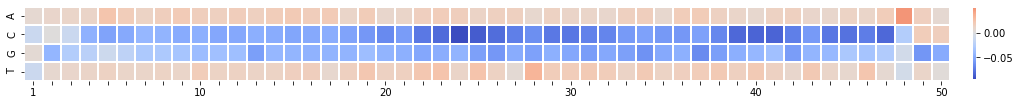

3942


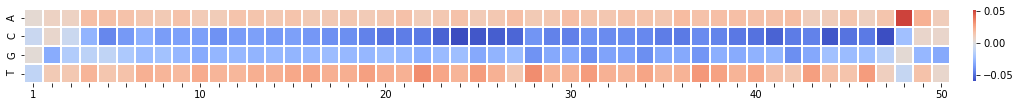

In [20]:
plot_meta(no_aug_pred_human, hmrl_model_no_aug, subset = 'highest_ten')
plot_meta(no_aug_pred_human, hmrl_model_no_aug, subset = 'lowest_ten')
plot_meta(no_aug_pred_human, hmrl_model_no_aug)

We can observe 'TG' in the start of some utrs as an artificially introduced signal from the experimental design. Therefore we perform attribution without these sequences for both conditions.

In [21]:
#import utrs with measured and predicted mean ribosome load

#synthetic utrs with mean ribosome load predicted by MRL model (trained on synthetic utrs without AUG and UG as first two nucleotides)
no_ug_pred_random=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/MRL_no_ug_random_test_pred.csv', index_col=[0])

#human utrs with mean ribosome load predicted by hMRL model (trained on human utrs without AUG and UG as first two nucleotides)
no_ug_pred_human=pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/mlcis/data/hMRL_no_ug_human_test_pred.csv', index_col=[0])

#import the two models trained on human/synthetic utrs without AUG respectively
mrl_model_no_ug=tf.keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/MRL_model_no_ug.hdf5')
hmrl_model_no_ug=tf.keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/mlcis/models/hMRL_model_no_ug.hdf5')

5


/Users/frederickkorbel/anaconda3/envs/mlcis/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


5
582


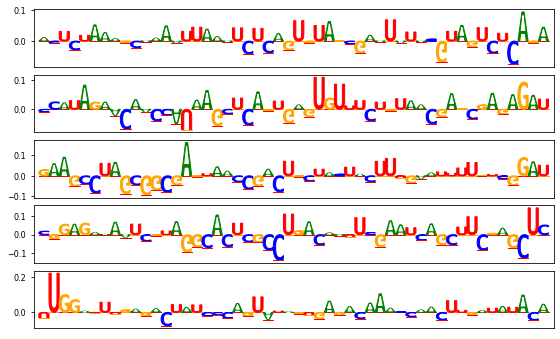

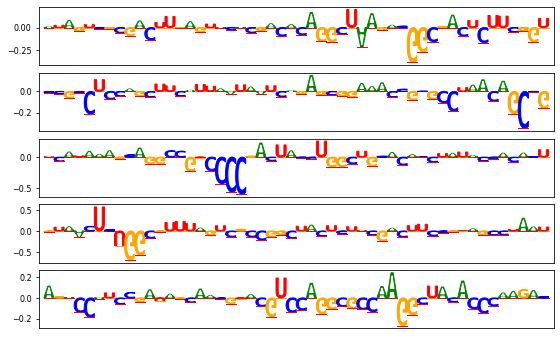

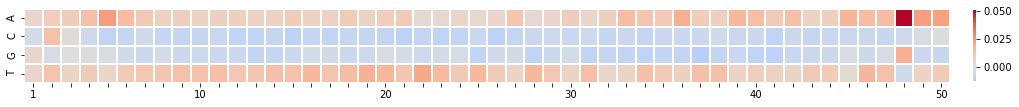

582


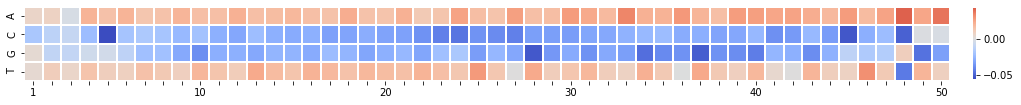

In [22]:
plot_attribution(no_ug_pred_random, mrl_model_no_aug, subset='highest_ten',samples=5)
plot_attribution(no_ug_pred_random, mrl_model_no_aug, subset='lowest_ten',samples=5)

plot_meta(no_ug_pred_random, mrl_model_no_aug, subset = 'highest_ten')
plot_meta(no_ug_pred_random, mrl_model_no_aug, subset = 'lowest_ten')

5
5
386


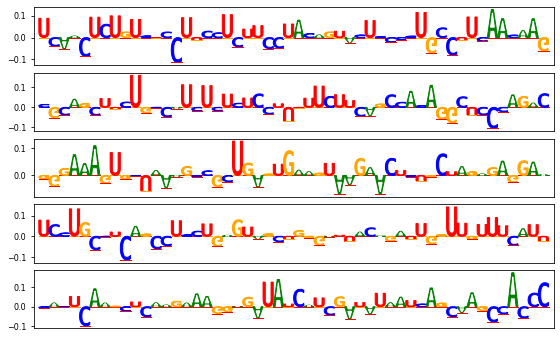

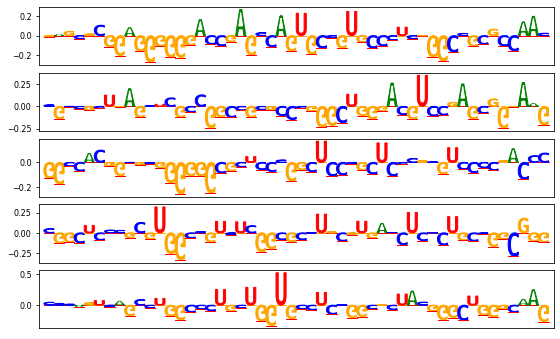

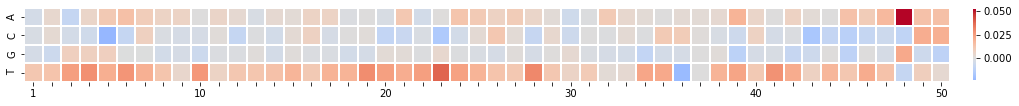

386


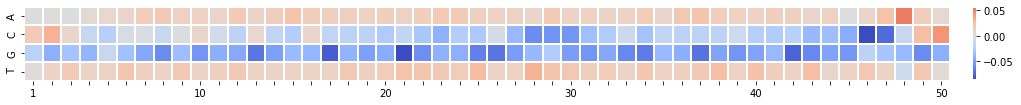

In [23]:
plot_attribution(no_ug_pred_human, hmrl_model_no_ug, subset='highest_ten',samples=5)
plot_attribution(no_ug_pred_human, hmrl_model_no_ug, subset='lowest_ten',samples=5)

plot_meta(no_ug_pred_human, hmrl_model_no_ug, subset = 'highest_ten')
plot_meta(no_ug_pred_human, hmrl_model_no_ug, subset = 'lowest_ten')

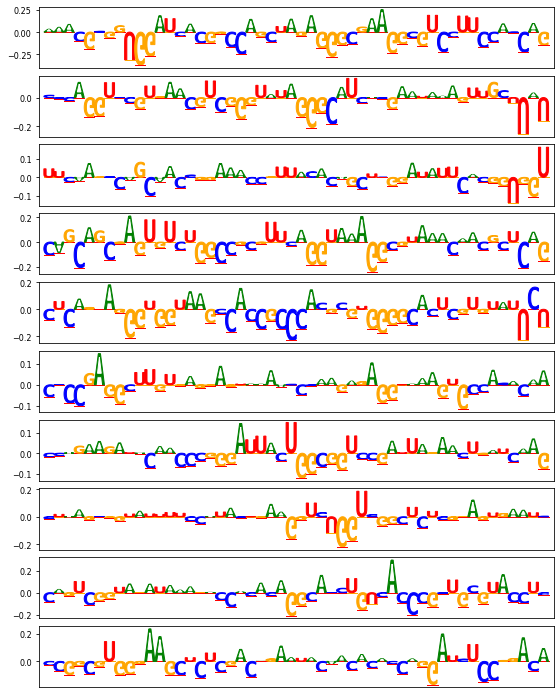

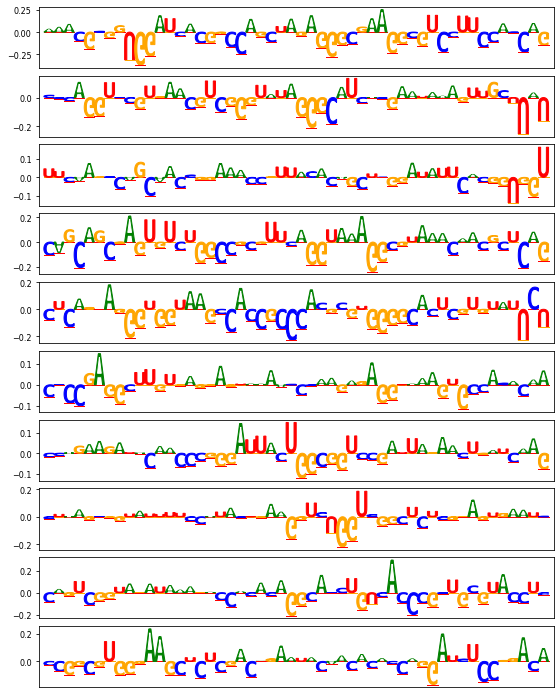

In [26]:
#test
weird_seqs=no_ug_pred_random[no_ug_pred_random['rl']<5]
d = weird_seqs.sample(n=10)
d_seq = one_hot_encode(d, seq_len=50)
d_ig = ig.integrated_gradients(mrl_model_no_ug, d_seq)
sql.seqlogo_fig(np.transpose(d_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,10), ncol=1)

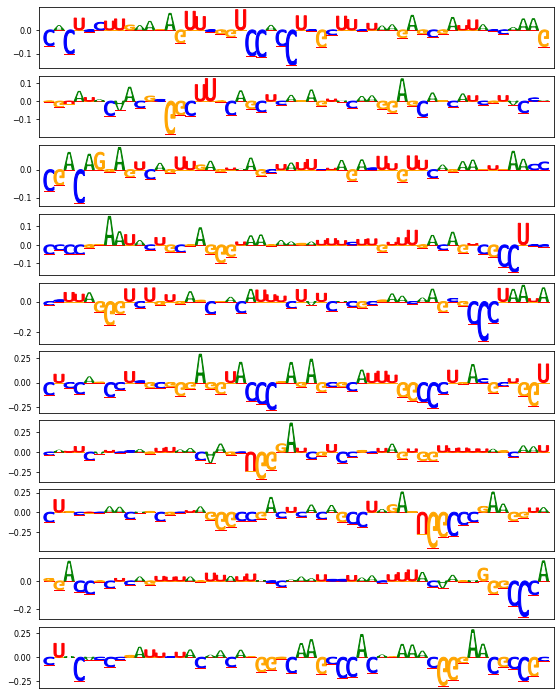

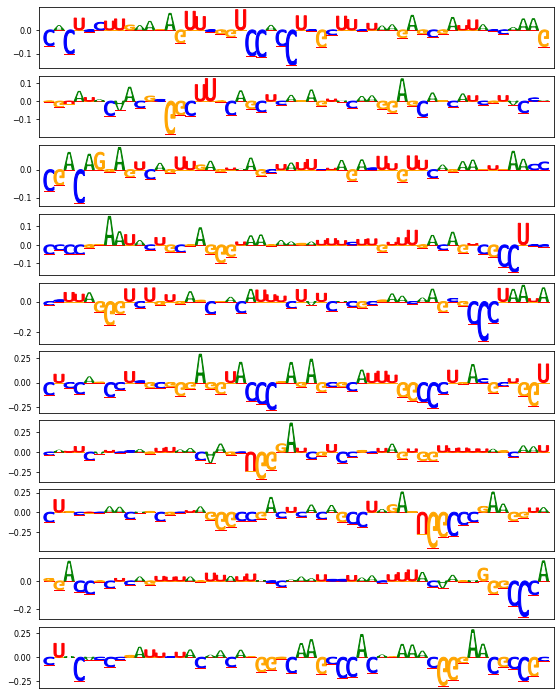

In [27]:
weird_seqs=no_ug_pred_random[no_ug_pred_random['rl']>6]
d = weird_seqs.sample(n=10)
d_seq = one_hot_encode(d, seq_len=50)
d_ig = ig.integrated_gradients(mrl_model_no_ug, d_seq)
sql.seqlogo_fig(np.transpose(d_ig, axes=(1,2,0)), vocab='RNA', figsize=(8,10), ncol=1)